---
title: "Data Cleaning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

## Merge Gender Dataset and CIK Codes Dataset

We merged the required company gender data with the CIK codes table to create a unified dataset. This integrated data serves as a reliable foundation for subsequent data collection.

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from fancyimpute import IterativeImputer
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [29]:
# Read CSV
df_gender = pd.read_csv("../../data/raw-data/company_gender_data.csv")
df_cik = pd.read_csv("../../data/raw-data/company_cik_list.csv")

In [30]:
df_gender.head()

,WBA_ID,Company-name,ISIN,SEDOL Code,Region,Country,Industry,Total,Percentage of Total Possible Score \n (out of 52.3),CEO Gender,...,VHR-E02.EA-Explanation,VHR-E02.EA-Evidence,VHR-E02.EA-Source,VHR-E02.EA-Link,VHR-E02.EB-Score,VHR-E02.EB-Assessment,VHR-E02.EB-Explanation,VHR-E02.EB-Evidence,VHR-E02.EB-Source,VHR-E02.EB-Link
0,PT_00001,3M Company,US88579Y1010,2595708,North America,United States,Chemicals,11.3,21.6,Male,...,No evidence was found regarding whether the co...,NaN,Sustainability Report_CY-2022,https://multimedia.3m.com/mws/media/2292786O/3...,0.0,Unmet,No evidence was found regarding whether the co...,NaN,Sustainability Report_CY-2022,https://multimedia.3m.com/mws/media/2292786O/3...
1,PT_00006,AbbVie,US00287Y1091,B92SR70,North America,United States,Pharmaceuticals & Biotechnology,15.4,29.5,Male,...,No evidence was found regarding whether the co...,NaN,The AbbVie Code of Business Conduct,https://investors.abbvie.com/static-files/09fd...,0.0,Unmet,No evidence was found regarding whether the co...,NaN,The AbbVie Code of Business Conduct,https://investors.abbvie.com/static-files/09fd...
2,PT_00007,Abercrombie & Fitch,US0028962076,2004185,North America,United States,Apparel & Footwear,10.0,19.1,Female,...,No evidence was found regarding whether the co...,NaN,NaN,NaN,0.0,Unmet,No evidence was found regarding whether the co...,NaN,Form 10-K_2022-2023,https://abercrombieandfitchcompany.gcs-web.com...
3,PT_00024,Adobe,US00724F1012,2008154,North America,United States,Digital,16.5,31.6,Male,...,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://www.adobe.com/content/dam/cc/en/corpor...,0.0,Unmet,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://www.adobe.com/content/dam/cc/en/corpor...
4,PT_00027,AMD,US0079031078,2007849,North America,United States,Digital,11.2,21.5,Female,...,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://d1io3yog0oux5.cloudfront.net/_ebdf5d9e...,0.0,Unmet,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://d1io3yog0oux5.cloudfront.net/_ebdf5d9e...


In [31]:
df_cik.head()

,Company-name,CIK-code
0,3M Company,CIK0000066740
1,AbbVie,CIK0001551152
2,Abercrombie & Fitch,CIK0001018840
3,Adobe,CIK0000008680
4,AMD,CIK0000002488


In [32]:
# Merge two dataframes
df_company = pd.merge(df_cik, df_gender, on="Company-name", how="inner")

We dropped the NA values of two variables: CEO Gender and CIK-code, which are two of the most important variables, to ensure we can collect the data from EDGAR API successfully.

In [33]:
# Check "CEO Gender" and "CIK Code" for NA values
missing_ceo_gender = df_company['CEO Gender'].isna().sum()
missing_cik_code = df_company['CIK-code'].isna().sum()

print(f"Number of missing values in 'CEO Gender': {missing_ceo_gender}")
print(f"Number of missing values in 'CIK Code': {missing_cik_code}")

Number of missing values in 'CEO Gender': 4
Number of missing values in 'CIK Code': 35


In [34]:
# Delete rows containing NA values in 'CEO Gender' and 'CIK Code'
df_company = df_company.dropna(subset=['CEO Gender', 'CIK-code'])

In [35]:
df_company.head()

,Company-name,CIK-code,WBA_ID,ISIN,SEDOL Code,Region,Country,Industry,Total,Percentage of Total Possible Score \n (out of 52.3),...,VHR-E02.EA-Explanation,VHR-E02.EA-Evidence,VHR-E02.EA-Source,VHR-E02.EA-Link,VHR-E02.EB-Score,VHR-E02.EB-Assessment,VHR-E02.EB-Explanation,VHR-E02.EB-Evidence,VHR-E02.EB-Source,VHR-E02.EB-Link
0,3M Company,CIK0000066740,PT_00001,US88579Y1010,2595708,North America,United States,Chemicals,11.3,21.6,...,No evidence was found regarding whether the co...,NaN,Sustainability Report_CY-2022,https://multimedia.3m.com/mws/media/2292786O/3...,0.0,Unmet,No evidence was found regarding whether the co...,NaN,Sustainability Report_CY-2022,https://multimedia.3m.com/mws/media/2292786O/3...
1,AbbVie,CIK0001551152,PT_00006,US00287Y1091,B92SR70,North America,United States,Pharmaceuticals & Biotechnology,15.4,29.5,...,No evidence was found regarding whether the co...,NaN,The AbbVie Code of Business Conduct,https://investors.abbvie.com/static-files/09fd...,0.0,Unmet,No evidence was found regarding whether the co...,NaN,The AbbVie Code of Business Conduct,https://investors.abbvie.com/static-files/09fd...
2,Abercrombie & Fitch,CIK0001018840,PT_00007,US0028962076,2004185,North America,United States,Apparel & Footwear,10.0,19.1,...,No evidence was found regarding whether the co...,NaN,NaN,NaN,0.0,Unmet,No evidence was found regarding whether the co...,NaN,Form 10-K_2022-2023,https://abercrombieandfitchcompany.gcs-web.com...
3,Adobe,CIK0000008680,PT_00024,US00724F1012,2008154,North America,United States,Digital,16.5,31.6,...,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://www.adobe.com/content/dam/cc/en/corpor...,0.0,Unmet,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://www.adobe.com/content/dam/cc/en/corpor...
4,AMD,CIK0000002488,PT_00027,US0079031078,2007849,North America,United States,Digital,11.2,21.5,...,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://d1io3yog0oux5.cloudfront.net/_ebdf5d9e...,0.0,Unmet,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://d1io3yog0oux5.cloudfront.net/_ebdf5d9e...


In [36]:
df_company.shape

(211, 303)

In [37]:
# Define output path
output_company_data_path = "../../data/processed-data/company_data.csv"

# Save CSV
df_company.to_csv(output_company_data_path, index=False)
print(f"Cleaned data saved to: {output_company_data_path}")

Cleaned data saved to: ../../data/processed-data/company_data.csv


## Clean Financial Dataset

After data collection, we read the financial dataset now. Large numerical values were scaled down to thousands (k) and the column names were updated accordingly. This step ensures the data remains intact while being easier to interpret in subsequent analyses.

In [38]:
df_fina = pd.read_csv("../../data/processed-data/financial_data.csv")

In [39]:
df_fina.head()

,CIK-code,NetIncomeLoss,OperatingIncomeLoss,GrossProfit,ComprehensiveIncomeNetOfTax,EarningsPerShareBasic,RevenueFromContractWithCustomerExcludingAssessedTax,EntityPublicFloat,AllocatedShareBasedCompensationExpense,CashAndCashEquivalentsAtCarryingValue,AccountsReceivableNetCurrent,Assets
0,CIK0000014693,9.030000e+08,1.166000e+09,2.094000e+09,1.028000e+09,1.89,3.461000e+09,2.340000e+10,NaN,1.150000e+09,8.130000e+08,6.373000e+09
1,CIK0001868275,-2.050000e+08,-3.460000e+08,NaN,-2.060000e+08,0.00,1.725400e+10,2.939646e+10,47000000.0,5.040000e+08,2.585000e+09,4.690900e+10
2,CIK0000877890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CIK0000004447,5.590000e+08,NaN,NaN,9.080000e+08,1.82,7.683000e+09,3.759800e+10,77000000.0,2.486000e+09,NaN,2.169500e+10
4,CIK0001307954,1.045000e+09,7.310000e+08,1.584000e+09,1.188000e+09,4.77,7.670000e+09,4.518833e+09,30000000.0,6.540000e+08,NaN,8.220000e+09


In [40]:
df_fina.shape

(202, 12)

In [41]:
df_fina.isna().sum()

CIK-code                                                 0
NetIncomeLoss                                           23
OperatingIncomeLoss                                     38
GrossProfit                                            110
ComprehensiveIncomeNetOfTax                             22
EarningsPerShareBasic                                   20
RevenueFromContractWithCustomerExcludingAssessedTax     84
EntityPublicFloat                                       13
AllocatedShareBasedCompensationExpense                  64
CashAndCashEquivalentsAtCarryingValue                   23
AccountsReceivableNetCurrent                            52
Assets                                                   8
dtype: int64

In this stage, we do not drop any NA value since otherwise there will only be about 30 rows.

In [42]:
# Convert large numbers (>= 1000) to 'k' (thousands) scale
for col in df_fina.select_dtypes(include=['float64', 'int64']).columns:
    if df_fina[col].max() >= 1000 or df_fina[col].min() < -1000:  # Check if column has large numbers
        # Divide all large numbers by 1000
        df_fina[col] = df_fina[col].apply(lambda x: x / 1000 if abs(x) >= 1000 else x)
        # Rename the column to indicate 'k'
        df_fina.rename(columns={col: f"{col} (k)"}, inplace=True)

## Merge Financial Dataset and Company Dataset

The financial dataset was merged with the company dataset using the common CIK-code key through an inner join. This step combines financial and company-specific data into a single unified dataset, enabling comprehensive analysis across both datasets.

In [43]:
# Load CSV
company_data = pd.read_csv('../../data/processed-data/company_data.csv')

In [44]:
# Merge the two datasets on the 'CIK-code' key
merged_data = pd.merge(df_fina, company_data, on='CIK-code', how='inner')
merged_data.head()

,CIK-code,NetIncomeLoss (k),OperatingIncomeLoss (k),GrossProfit (k),ComprehensiveIncomeNetOfTax (k),EarningsPerShareBasic,RevenueFromContractWithCustomerExcludingAssessedTax (k),EntityPublicFloat (k),AllocatedShareBasedCompensationExpense (k),CashAndCashEquivalentsAtCarryingValue (k),...,VHR-E02.EA-Explanation,VHR-E02.EA-Evidence,VHR-E02.EA-Source,VHR-E02.EA-Link,VHR-E02.EB-Score,VHR-E02.EB-Assessment,VHR-E02.EB-Explanation,VHR-E02.EB-Evidence,VHR-E02.EB-Source,VHR-E02.EB-Link
0,CIK0000014693,903000.0,1166000.0,2094000.0,1028000.0,1.89,3461000.0,2.340000e+07,NaN,1150000.0,...,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://www.brown-forman.com/sites/default/fil...,0.0,Unmet,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://www.brown-forman.com/sites/default/fil...
1,CIK0001868275,-205000.0,-346000.0,NaN,-206000.0,0.00,17254000.0,2.939646e+07,47000.0,504000.0,...,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://investors.constellationenergy.com/stat...,0.0,Unmet,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://investors.constellationenergy.com/stat...
2,CIK0000877890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,This assessment only evaluated publicly availa...,NaN,NaN,NaN,0.0,Unmet,This assessment only evaluated publicly availa...,NaN,NaN,NaN
3,CIK0000004447,559000.0,NaN,NaN,908000.0,1.82,7683000.0,3.759800e+07,77000.0,2486000.0,...,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://investors.hess.com/static-files/d4010f...,0.0,Unmet,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://investors.hess.com/static-files/d4010f...
4,CIK0001307954,1045000.0,731000.0,1584000.0,1188000.0,4.77,7670000.0,4.518833e+06,30000.0,654000.0,...,No evidence was found regarding whether the co...,NaN,Code of Conduct / Code of Ethics_2022-2023,https://d1io3yog0oux5.cloudfront.net/huntsman/...,0.0,Unmet,No evidence was found regarding whether the co...,NaN,Sustainability Report_CY-2022,https://issuu.com/graphicengine/docs/huntsman-...


## Text data Cleaning

To prepare the dataset for analysis, we cleaned text data cleaning across all relevant fields, which removed unnecessary noise. We want to improves the quality of the dataset, allowing for more accurate insights and meaningful results in subsequent analyses.

We customized the default English stopwords list from the NLTK library by removing negative words such as "no," "not," and "never" to retain them for text analysis. This step ensures that important contextual information related to negations is preserved while irrelevant stopwords are excluded.

In [45]:
stop_words = set(stopwords.words('english'))
print("stop words:", stop_words)

stop words: {'o', 'himself', 'those', "don't", "she's", 'under', 'most', 'will', 'ours', 'some', 'i', 'at', 'myself', 'yours', 'were', 'just', 'haven', 'he', 'until', 's', 'over', 'all', 'is', "needn't", 'd', 'me', 'against', 'yourself', 'do', 'when', 'between', 'y', 'shouldn', 'in', 'because', "isn't", 'shan', 'from', 'had', 'only', 'can', 'couldn', 'doesn', "mightn't", "didn't", 'isn', 'with', 'who', 'how', 'again', 'm', 'are', "haven't", 'him', 'not', 'after', 'they', 'about', 'out', 'been', 'mustn', 'themselves', 'this', 'our', "you're", 'her', 'of', 'mightn', 'doing', 'theirs', 'below', 'once', 'above', 'ain', 'into', 'hasn', 'any', 'should', 'wouldn', 'few', 'or', 'a', 'these', "you'd", "shan't", 'whom', 'didn', 'as', 'am', 'hadn', 'his', 'up', 'the', 'than', "weren't", 'off', 'here', 'their', 'which', 'during', "hasn't", 'them', 'was', 'herself', 'through', "doesn't", 'what', 'other', 'why', 'now', 'to', 'there', "mustn't", "won't", "you've", "couldn't", 're', 'if', 'has', 'too'

We cleaned the Explanation and Evidence columns by removing non-English characters, HTML tags, special symbols, and extra spaces while retaining negation words. This process improved the clarity and usability of the text data.

In [46]:
# Define the text cleaning function
def clean_text(text):
    """
    Cleans the input text by:
    1. Removing non-English characters.
    2. Removing HTML tags.
    3. Removing special characters.
    4. Removing extra spaces.
    """
    if isinstance(text, str):  # Only process strings
        # Convert text to lowercase
        text = text.lower()
        # Remove HTML tags
        text = re.sub(r'<[^>]*>', '', text)
        # Keep only English letters, numbers, and spaces
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        # Remove stop words (keeping 'no')
        words = text.split()
        cleaned_words = [word for word in words if word not in stop_words]
        return ' '.join(cleaned_words)

In [47]:
# Select all columns containing 'Explanation'
explanation_columns = [col for col in merged_data.columns if 'Explanation' in col]

# Print the selected column names
print("Columns to clean:", explanation_columns)

Columns to clean: ['SA-A01.EA-Explanation', 'GT-A02.EA-Explanation', 'GT-A02.EC-Explanation', 'GDD-A04.EA-Explanation', 'GDD-A04.EB-Explanation', 'GM-A05.EA-Explanation', 'GM-A05.EB-Explanation', 'GM-A05.EC-Explanation', 'SE-A06.EA-Explanation', 'CAP-A07.EA-Explanation', 'CAP-A07.EB-Explanation', 'GL-B01.EA-Explanation', 'GL-B01.EB-Explanation', 'GL-B01.EC-Explanation', 'GL-B01.ED-Explanation', 'PD-B02.EA-Explanation', 'PD-B02.EB-Explanation', 'SD-B03.EA- Explanation', 'SD-B03.EB-Explanation', 'SD-B03.EC-Explanation', 'SD-B03.ED-Explanation', 'SC-B04.EA- Explanation', 'EE-B06.EB-Explanation', 'GR-B07.EA- Explanation', 'GR-B07.EB-Explanation', 'GPG-C01.EA-Explanation', 'GPG-C01.EB-Explanation', 'GPG-C01.EC-Explanation', 'PCL-C02.EA-Explanation', 'PCL-C02.EB-Explanation', 'PCL-C02.EC-Explanation', 'PCL-C02.ED-Explanation', 'CFS-C03.EA-Explanation', 'CFS-C03.EB-Explanation', 'FW-C04.EA-Explanation', 'FW-C04.EB-Explanation', 'FW-C04.EC-Explanation', 'FW-C04.ED-Explanation', 'LWS-C06.EA-Exp

In [48]:
# Apply the cleaning function to the selected columns
for col in explanation_columns:
    merged_data[col] = merged_data[col].apply(clean_text)

In [49]:
print(merged_data[explanation_columns].head())

                               SA-A01.EA-Explanation  \
0  company states committed equality opportunity ...   
1  company states values individual differences p...   
2  company states committed equal employment oppo...   
3  company states remains committed professional ...   
4  evidence company public commitment gender equa...   

                               GT-A02.EA-Explanation  \
0  company identified specific timebound targets ...   
1  evidence found whether company identified spec...   
2  evidence found whether company identified spec...   
3  evidence found whether company identified spec...   
4  evidence found whether company identified spec...   

                               GT-A02.EC-Explanation  \
0  company discloses one timebound targets gender...   
1  evidence found timebound targets gender equali...   
2  evidence found timebound targets gender equali...   
3  evidence found timebound targets gender equali...   
4  evidence found timebound targets gender equ

In [50]:
# Select all columns containing 'Evidence'
evidence_columns = [col for col in merged_data.columns if 'Evidence' in col]

# Print the selected column names
print("Columns to clean:", evidence_columns)

Columns to clean: ['SA-A01.EA-Evidence', 'GT-A02.EA-Evidence', 'GT-A02.EC-Evidence', 'GDD-A04.EA-Evidence', 'GDD-A04.EB-Evidence', 'GM-A05.EA-Evidence', 'GM-A05.EB-Evidence', 'GM-A05.EC-Evidence', 'SE-A06.EA-Evidence', 'CAP-A07.EA-Evidence', 'CAP-A07.EB-Evidence', 'GL-B01.EA-Evidence', 'GL-B01.EB-Evidence', 'GL-B01.EC-Evidence', 'GL-B01.ED-Evidence', 'GL-B01.EE-Evidence', 'PD-B02.EA-Evidence', 'PD-B02.EB-Evidence', 'SD-B03.EA- Evidence', 'SD-B03.EB-Evidence', 'SD-B03.EC-Evidence', 'SD-B03.ED-Evidence', 'SC-B04.EA- Evidence', 'EE-B06.EB-Evidence', 'GR-B07.EA- Evidence', 'GR-B07.EB-Evidence', 'GPG-C01.EA-Evidence', 'GPG-C01.EB-Evidence', 'GPG-C01.EC-Evidence', 'PCL-C02.EA-Evidence', 'PCL-C02.EB-Evidence', 'PCL-C02.EC-Evidence', 'PCL-C02.ED-Evidence', 'CFS-C03.EA-Evidence', 'CFS-C03.EB-Evidence', 'FW-C04.EA-Evidence', 'FW-C04.EB-Evidence', 'FW-C04.EC-Evidence', 'FW-C04.ED-Evidence', 'LWS-C06.EA-Evidence', 'LWS-C06.EB-Evidence', 'HSW-D01.EA-Evidence', 'HSW-D01.EB-Evidence', 'HSW-D01.EC-Evi

In [51]:
# Apply the cleaning function to the selected columns
for col in evidence_columns:
    merged_data[col] = merged_data[col].apply(clean_text)

# Preview the cleaned data
print(merged_data[evidence_columns].head())

                                  SA-A01.EA-Evidence  \
0  brownforman committed equality opportunity asp...   
1  constellation operates world thats extremely d...   
2  citrix firmly committed equal employment oppor...   
3  remain committed professional growth women 202...   
4                                               None   

                                  GT-A02.EA-Evidence  \
0                                               None   
1                                               None   
2  citrix recently increased number female execut...   
3                                               None   
4                                               None   

                                  GT-A02.EC-Evidence  \
0                                               None   
1                                               None   
2  citrix recently increased number female execut...   
3                                               None   
4                                             

To make analysis easier, we created new binary columns for all Evidence fields in the dataset, indicating whether evidence exists (1) or is missing (0). This step ensures a clear way to analyze and filter the data based on the availability of evidence for specific variables.

In [52]:
# Create a dictionary to store new columns
new_columns = {}

for col in evidence_columns:
    # Create new column name
    new_col = f"{col}-has_evidence"
    # Store the new column in the dictionary
    new_columns[new_col] = np.where(merged_data[col].isna(), 0, 1)

# Add all new columns to the DataFrame at once
merged_data = pd.concat([merged_data, pd.DataFrame(new_columns)], axis=1)

# Preview the updated DataFrame
print(merged_data[[col for col in merged_data.columns if 'has_evidence' in col]].head())

   SA-A01.EA-Evidence-has_evidence  GT-A02.EA-Evidence-has_evidence  \
0                                1                                0   
1                                1                                0   
2                                1                                1   
3                                1                                0   
4                                0                                0   

   GT-A02.EC-Evidence-has_evidence  GDD-A04.EA-Evidence-has_evidence  \
0                                0                                 0   
1                                0                                 0   
2                                1                                 0   
3                                0                                 1   
4                                0                                 0   

   GDD-A04.EB-Evidence-has_evidence  GM-A05.EA-Evidence-has_evidence  \
0                                 0                                1

In [53]:
# Save the merged dataset to a new CSV
output_merged_data_path = '../../data/processed-data/merged_data.csv'
merged_data.to_csv(output_merged_data_path, index=False)

## Financial Data Cleaning

In the EDA phase, we aim to explore the raw structure of the numerical data, so no transformations will be applied to numerical data. However, after exploration, we have decided to apply standardization in both the supervised and unsupervised learning phases, depending on the specific goals of each exploration. These steps will be reflected in the respective code sections. Since the data processing steps for supervised learning are more complex, we will detail them in this section. However, these steps are also presented in the dedicated section for supervised learning, which includes the selection of necessary subsets. Specifically, we will first apply Z-score transformation, followed by Min-Max scaling, and finally use multiple imputation for missing data.

### Before cleaning visualization

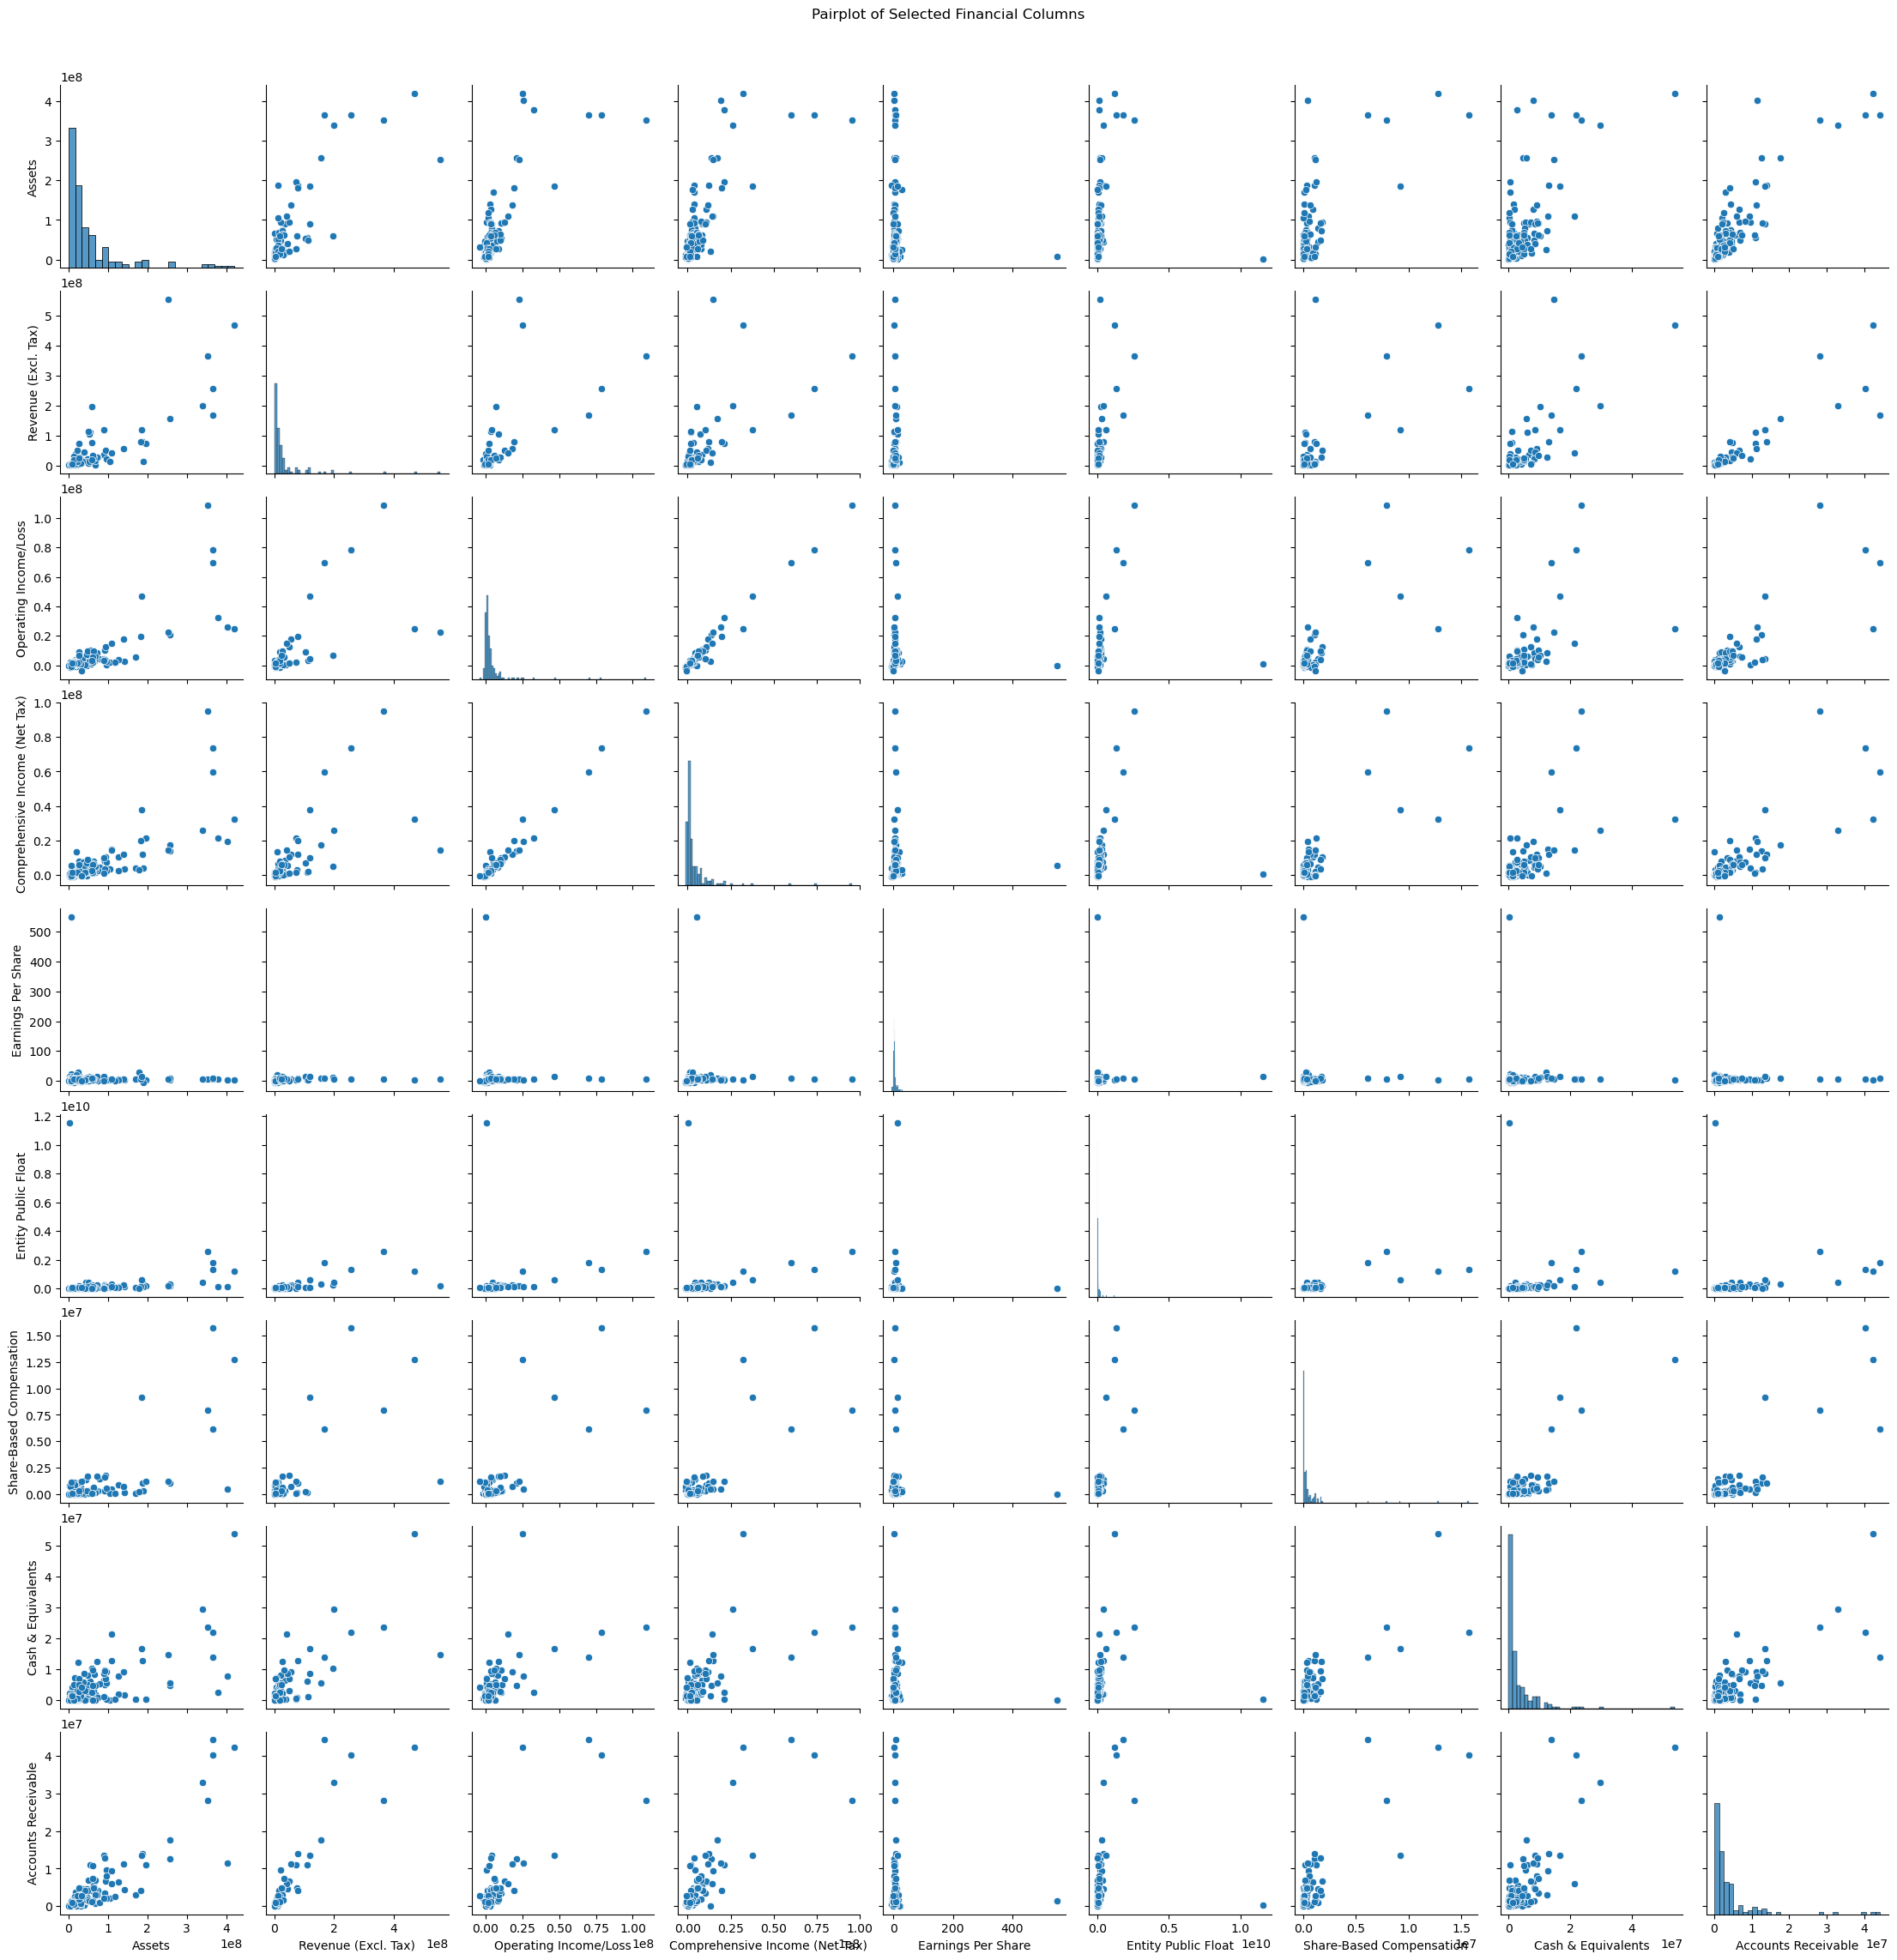

In [14]:
columns_to_plot = ['Assets (k)', 'RevenueFromContractWithCustomerExcludingAssessedTax (k)', 
                   'OperatingIncomeLoss (k)', 'ComprehensiveIncomeNetOfTax (k)',
                   'EarningsPerShareBasic', 'EntityPublicFloat (k)', 
                   'AllocatedShareBasedCompensationExpense (k)', 
                   'CashAndCashEquivalentsAtCarryingValue (k)', 'AccountsReceivableNetCurrent (k)']

column_labels = {
    'Assets (k)': 'Assets',
    'RevenueFromContractWithCustomerExcludingAssessedTax (k)': 'Revenue (Excl. Tax)',
    'OperatingIncomeLoss (k)': 'Operating Income/Loss',
    'ComprehensiveIncomeNetOfTax (k)': 'Comprehensive Income (Net Tax)',
    'EarningsPerShareBasic': 'Earnings Per Share',
    'EntityPublicFloat (k)': 'Entity Public Float',
    'AllocatedShareBasedCompensationExpense (k)': 'Share-Based Compensation',
    'CashAndCashEquivalentsAtCarryingValue (k)': 'Cash & Equivalents',
    'AccountsReceivableNetCurrent (k)': 'Accounts Receivable'
}

# Replace the column names with the shorter labels in the DataFrame
df_renamed = merged_data[columns_to_plot].rename(columns=column_labels)

# Create a pairplot with the shortened column names
sns.pairplot(df_renamed)
plt.suptitle('Pairplot of Selected Financial Columns', y=1.02)
plt.show()

### Cleaning

In [15]:
Asset_Profitability_columns = [
    'Assets (k)', 'RevenueFromContractWithCustomerExcludingAssessedTax (k)', 
    'OperatingIncomeLoss (k)', 'ComprehensiveIncomeNetOfTax (k)'
]

Liquidity_Market_columns = [
    'EarningsPerShareBasic', 'EntityPublicFloat (k)', 'AllocatedShareBasedCompensationExpense (k)',
    'CashAndCashEquivalentsAtCarryingValue (k)', 'AccountsReceivableNetCurrent (k)'
]
# Perform multiple imputation for missing values in the financial columns
imputer = IterativeImputer()
merged_data[Asset_Profitability_columns] = imputer.fit_transform(merged_data[Asset_Profitability_columns])
merged_data[Liquidity_Market_columns] = imputer.fit_transform(merged_data[Liquidity_Market_columns])

In [16]:
# Define the columns to normalize (financial columns + Total)
columns_to_standardize = Asset_Profitability_columns + Liquidity_Market_columns + ['Total']

# Apply Z-score normalization
scaler = StandardScaler()
merged_data[columns_to_standardize] = scaler.fit_transform(merged_data[columns_to_standardize])

# Apply Min-Max normalization to the same columns
min_max_scaler = MinMaxScaler()
merged_data[columns_to_standardize] = min_max_scaler.fit_transform(merged_data[columns_to_standardize])

### After cleaning visualization

In [17]:
merged_data[columns_to_standardize].head()

,Assets (k),RevenueFromContractWithCustomerExcludingAssessedTax (k),OperatingIncomeLoss (k),ComprehensiveIncomeNetOfTax (k),EarningsPerShareBasic,EntityPublicFloat (k),AllocatedShareBasedCompensationExpense (k),CashAndCashEquivalentsAtCarryingValue (k),AccountsReceivableNetCurrent (k),Total
0,0.014250,0.008925,0.044333,0.024057,0.014182,0.002023,0.011501,0.021303,0.017058,0.400749
1,0.110727,0.033700,0.030927,0.011276,0.010785,0.002541,0.017195,0.009315,0.057146,0.430712
2,0.129706,0.075024,0.081382,0.061669,0.024479,0.013596,0.053195,0.061063,0.084879,0.123596
3,0.050717,0.016509,0.043063,0.022815,0.014056,0.003250,0.018796,0.046096,0.056278,0.408240
4,0.018646,0.016485,0.040476,0.025715,0.019358,0.000391,0.016287,0.012099,0.034306,0.314607


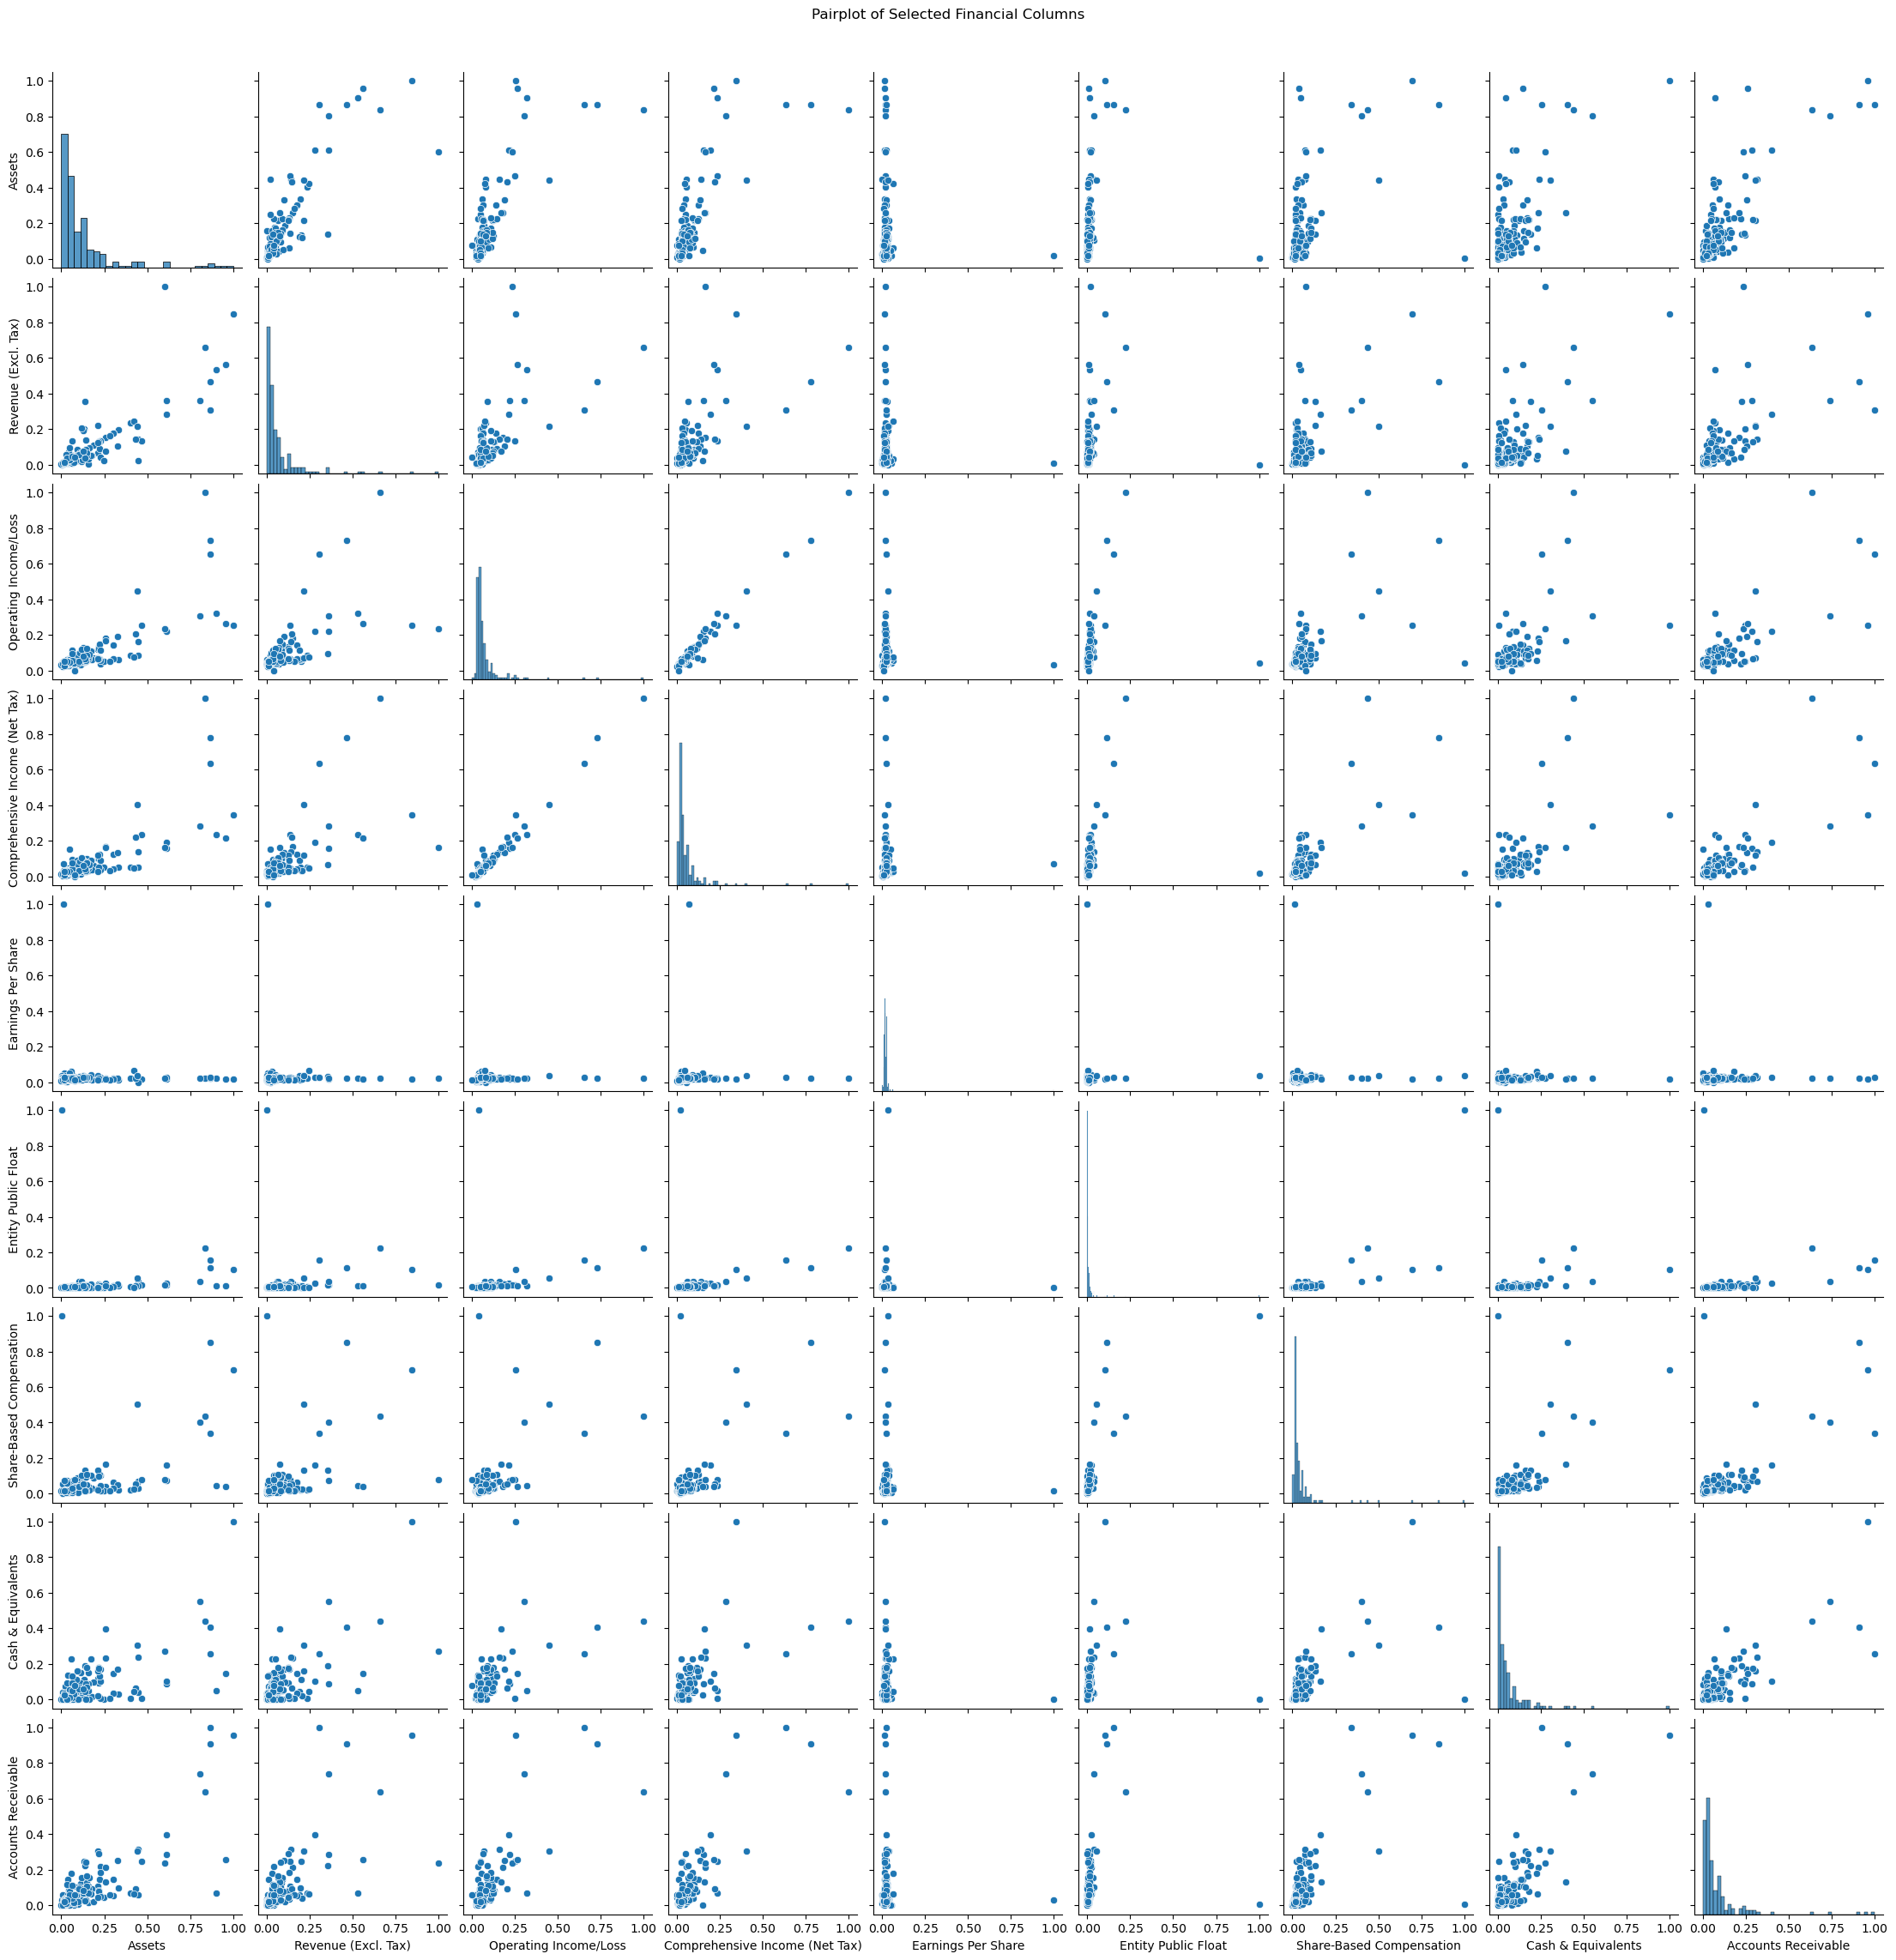

In [19]:
columns_to_plot = ['Assets (k)', 'RevenueFromContractWithCustomerExcludingAssessedTax (k)', 
                   'OperatingIncomeLoss (k)', 'ComprehensiveIncomeNetOfTax (k)',
                   'EarningsPerShareBasic', 'EntityPublicFloat (k)', 
                   'AllocatedShareBasedCompensationExpense (k)', 
                   'CashAndCashEquivalentsAtCarryingValue (k)', 'AccountsReceivableNetCurrent (k)']

column_labels = {
    'Assets (k)': 'Assets',
    'RevenueFromContractWithCustomerExcludingAssessedTax (k)': 'Revenue (Excl. Tax)',
    'OperatingIncomeLoss (k)': 'Operating Income/Loss',
    'ComprehensiveIncomeNetOfTax (k)': 'Comprehensive Income (Net Tax)',
    'EarningsPerShareBasic': 'Earnings Per Share',
    'EntityPublicFloat (k)': 'Entity Public Float',
    'AllocatedShareBasedCompensationExpense (k)': 'Share-Based Compensation',
    'CashAndCashEquivalentsAtCarryingValue (k)': 'Cash & Equivalents',
    'AccountsReceivableNetCurrent (k)': 'Accounts Receivable'
}

# Replace the column names with the shorter labels in the DataFrame
df_renamed_2 = merged_data[columns_to_plot].rename(columns=column_labels)

# Create a pairplot with the shortened column names
sns.pairplot(df_renamed_2)
plt.suptitle('Pairplot of Selected Financial Columns', y=1.02)
plt.show()

# Summary and Interpretation of Results

In order to explore the original characteristics of the data, we did not perform standardization or deal with missing values in the EDA phase. At the same time, the data filtering and some other data preprocessing steps will be performed in the supervised and unsupervised learning phases, and we will put the code in the corresponding sections. At these specific stages, we will conduct more in-depth data preprocessing based on our exploration goals, such as the input of missing values and the normalization of data. Because the filtered data sets are different at different stages of exploration, the corresponding processing steps will also be different.

To help viewers better understand the overall data processing workflow and the rationale behind our choices, we will explain these steps and processes in detail in the supervised and unsupervised learning sections. Therefore, the details of data filtering and related preprocessing will not be discussed in the data cleaning section, but will be elaborated in the subsequent model training section. However, we will still include some of the corresponding data processing to show the changes in the data visualization before and after we clean up (for supervised learning), while other processes will be discussed in more detail later.